# Synthetic Image Detection
---
### Tells if input image is real or fake.

### Mk-1 :- Basic CNN
### Mk-2 :- Transfer Learning (Using ResNet, VGG OR ViT)

### Data-preprocessing (GenImage dataset) :-

*   Resizing all the images to 224x224 (std. for ResNet like models)
*   Resizing was done locally using python + cmd.

### Scalability: Which generator was used.


## Data loading

In [ ]:
from google.colab import files
files.upload()   # upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sarthakghavghave","key":"75b51245c726fceff9c281f1e032c5b2"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# testing kaggle setup
# !kaggle datasets list -s cats

In [ ]:
!kaggle datasets download -d sarthakghavghave/biggan-from-genimage-resized-to-224x224

Dataset URL: https://www.kaggle.com/datasets/sarthakghavghave/biggan-from-genimage-resized-to-224x224
License(s): unknown
 99% 4.74G/4.77G [01:25<00:02, 12.4MB/s]
100% 4.77G/4.77G [01:26<00:00, 59.6MB/s]


In [ ]:
!unzip biggan-from-genimage-resized-to-224x224.zip -d /content/dataset/

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/BigGAN_Resized/val/nature/ILSVRC2012_val_00008906.jpg  
  inflating: /content/dataset/BigGAN_Resized/val/nature/ILSVRC2012_val_00008909.jpg  
  inflating: /content/dataset/BigGAN_Resized/val/nature/ILSVRC2012_val_00008920.jpg  
  inflating: /content/dataset/BigGAN_Resized/val/nature/ILSVRC2012_val_00008926.jpg  
  inflating: /content/dataset/BigGAN_Resized/val/nature/ILSVRC2012_val_00008936.jpg  
  inflating: /content/dataset/BigGAN_Resized/val/nature/ILSVRC2012_val_00008940.jpg  
  inflating: /content/dataset/BigGAN_Resized/val/nature/ILSVRC2012_val_00008945.jpg  
  inflating: /content/dataset/BigGAN_Resized/val/nature/ILSVRC2012_val_00008953.jpg  
  inflating: /content/dataset/BigGAN_Resized/val/nature/ILSVRC2012_val_00008961.jpg  
  inflating: /content/dataset/BigGAN_Resized/val/nature/ILSVRC2012_val_00008962.jpg  
  inflating: /content/dataset/BigGAN_Resized/val/nature/ILSVRC2012_val_00008966.jpg  
  i

In [ ]:
import os

train_dir = "/content/dataset/BigGAN_Resized/train"
test_dir = "/content/dataset/BigGAN_Resized/val"

# Check contents of the folders
print("Train Directory:", os.listdir(train_dir))
print("Test Directory:", os.listdir(test_dir))

Train Directory: ['ai', 'nature']
Test Directory: ['ai', 'nature']


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Only need ToTensor + Normalize because images are already resized
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets (ImageFolder -> scans all the folders and assigns (0/1) to each image based on folder)
train_dataset = datasets.ImageFolder(root="/content/dataset/BigGAN_Resized/train", transform=train_transform)
val_dataset = datasets.ImageFolder(root="/content/dataset/BigGAN_Resized/val", transform=test_transform)

# Dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Defining basic CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),       # Stabalized training
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.global_pool = nn.AdaptiveAvgPool2d(1)  # reduces HxW to 1x1

        self.fc_layers = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),          # Reduces overfitting
            nn.Linear(128, 1),        # logits
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.global_pool(x)   # B x 128 x 1 x 1
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Instantiate model
model = SimpleCNN()


In [ ]:
!pip install tqdm

## Training without checkpoints



In [ ]:
# import torch.optim as optim
# from tqdm import tqdm

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = SimpleCNN().to(device)

# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Learning Rate
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# epochs = 5

# # Training loop
# for epoch in range(epochs):
#     model.train()
#     running_loss = 0

#     print(f"Epoch {epoch+1}: ")
#     with tqdm(train_loader, unit="batch") as tepoch:
#         for images, labels in tepoch:
#             images, labels = images.to(device), labels.float().unsqueeze(1).to(device)

#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()

#             # Update the progress bar description with the current loss
#             tepoch.set_postfix(loss=running_loss/len(tepoch))

#     print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")
#     scheduler.step()

Epoch 1: 


100%|██████████| 10125/10125 [34:30<00:00,  4.89batch/s, loss=50]


Epoch 1/5, Loss: 49.9838
Epoch 2: 


100%|██████████| 10125/10125 [32:10<00:00,  5.24batch/s, loss=50]


Epoch 2/5, Loss: 49.9990
Epoch 3: 


 90%|████████▉ | 9064/10125 [27:21<03:04,  5.75batch/s, loss=44.8]

## Training with checkpoints

In [14]:
import torch.optim as optim
from tqdm import tqdm # for progress bar

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# Directory for saving checkpoints
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Load checkpoint if resuming
start_epoch = 0
checkpoint_path = os.path.join(checkpoint_dir, "last_checkpoint.pth")
if os.path.exists(checkpoint_path):
    print("Resuming from last checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    scheduler.load_state_dict(checkpoint["scheduler_state"])
    start_epoch = checkpoint["epoch"] + 1

# Training loop
epochs = 5
for epoch in range(start_epoch, epochs):
    model.train()
    running_loss = 0

    print(f"Epoch {epoch+1}/{epochs}: ")
    with tqdm(train_loader, unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            tepoch.set_postfix(loss=running_loss/len(tepoch))

    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    # Save checkpoint after each epoch
    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict()
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")


Epoch 1/5: 


100%|██████████| 10125/10125 [36:15<00:00,  4.65batch/s, loss=50]


Epoch 1, Loss: 49.9954
Checkpoint saved at checkpoints/last_checkpoint.pth
Epoch 2/5: 


100%|██████████| 10125/10125 [35:34<00:00,  4.74batch/s, loss=50]


Epoch 2, Loss: 49.9992
Checkpoint saved at checkpoints/last_checkpoint.pth
Epoch 3/5: 


100%|██████████| 10125/10125 [34:57<00:00,  4.83batch/s, loss=50]


Epoch 3, Loss: 49.9993
Checkpoint saved at checkpoints/last_checkpoint.pth
Epoch 4/5: 


100%|██████████| 10125/10125 [34:29<00:00,  4.89batch/s, loss=50]


Epoch 4, Loss: 49.9995
Checkpoint saved at checkpoints/last_checkpoint.pth
Epoch 5/5: 


100%|██████████| 10125/10125 [32:59<00:00,  5.12batch/s, loss=50]


Epoch 5, Loss: 49.9995
Checkpoint saved at checkpoints/last_checkpoint.pth


In [15]:
# torch.save(model.state_dict(), "BaseLine_CNN_MK1_weights.pth") # Save the model's state_dict (parameters)
torch.save(model, "Baseline_CNN_MK1.pth")

## Testing

In [16]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float()
        correct += (preds == labels.unsqueeze(1)).sum().item()
        total += labels.size(0)

print(f"Validation Accuracy: {correct/total:.4f}")

Validation Accuracy: 0.5000


In [17]:
from PIL import Image

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ]) # Transform (preprocessing must be SIMILER as used in data-loading)

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 3. Prediction Function
def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img_t = test_transform(img).unsqueeze(0).to(device) # Note: device needs to be specified while training, testing, and predicting (whenever using the model), and device(CPU or GPU) must be same for all

    with torch.no_grad():
        output = model(img_t)
        prob = output.item()

    if prob > 0.5:
        return f"Fake (AI-generated) with confidence {prob:.2f}"
    else:
        return f"Real (original) with confidence {1-prob:.2f}"

# 4. Test on User Input
img_path = "/content/ILSVRC2012_val_00000209.jpg"
print(predict_image(img_path))

Fake (AI-generated) with confidence 1.00


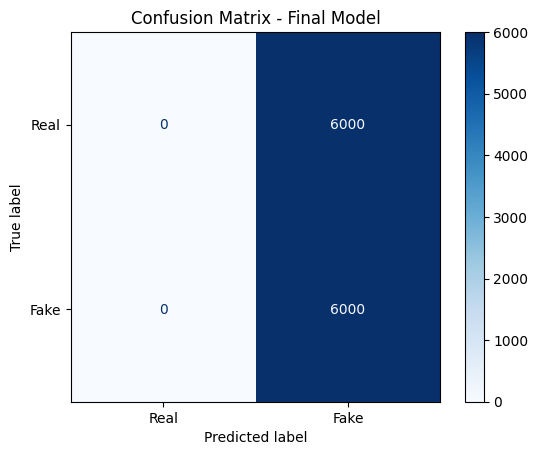

Final Validation Accuracy: 0.5000


In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

all_preds, all_labels = [], []

model.eval()  # Make sure model is in evaluation mode
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Final Model")
plt.show()

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Final validation accuracy
val_acc = (all_preds == all_labels).mean()
print(f"Final Validation Accuracy: {val_acc:.4f}")
